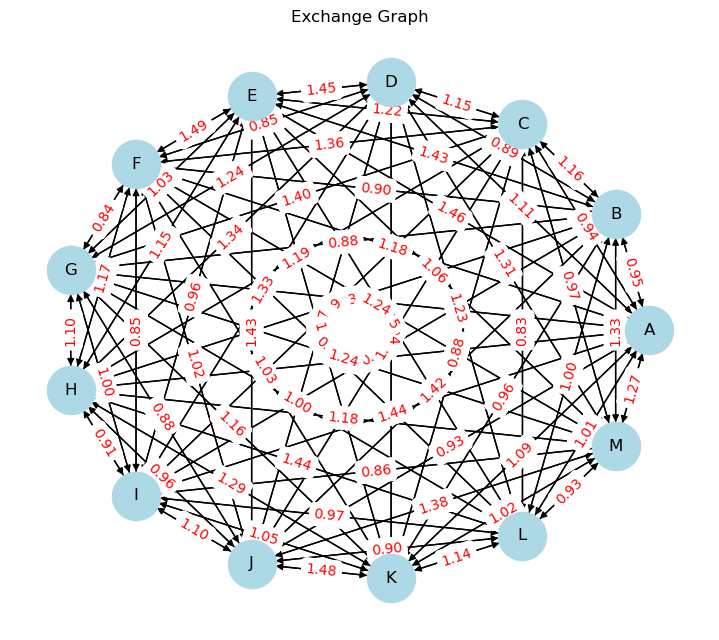

BQM has 156 variables
Running annealing...

Final energy: -26003.4323
Chosen edges: ['A->B', 'B->L', 'L->H', 'H->J', 'J->D', 'D->G', 'G->C', 'C->I', 'I->M', 'M->F', 'F->K', 'K->E', 'E->A']


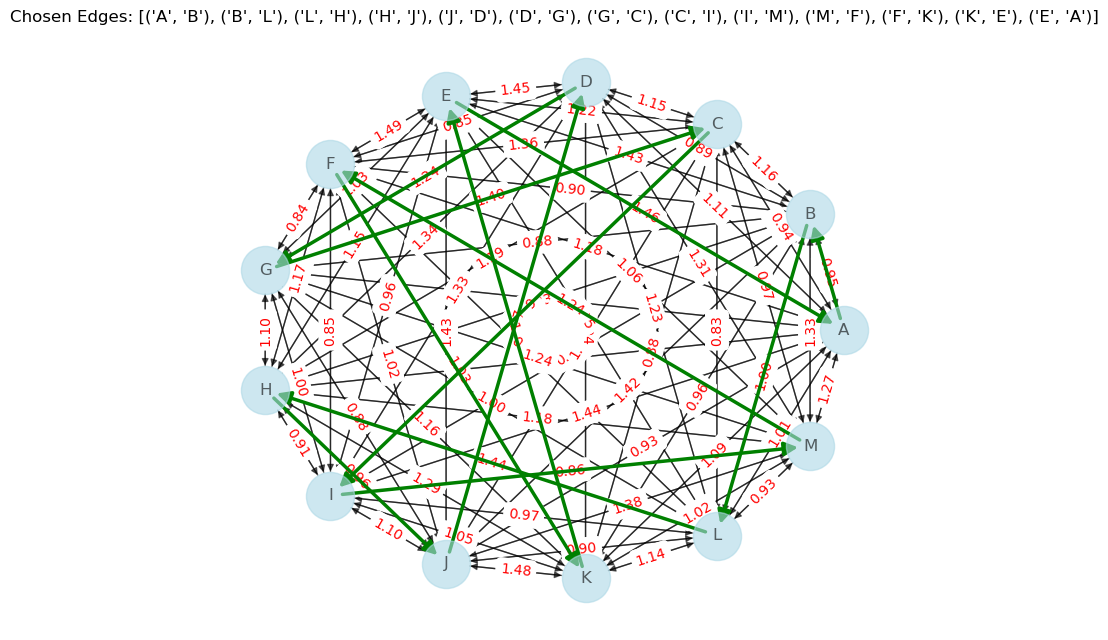

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler  # For simulation

###############################################################################
# 1) DATA GENERATION (kept from original)
###############################################################################
def generate_data(num_currencies=4, seed=42):
    """
    Randomly generate exchange rates and transaction fees.
    """
    np.random.seed(seed)
    currencies = [chr(65 + i) for i in range(num_currencies)]
    exchange_rates = np.random.uniform(0.8, 1.5, size=(num_currencies, num_currencies))
    np.fill_diagonal(exchange_rates, 1.0)

    transaction_fees = np.random.uniform(0.001, 0.01, size=(num_currencies, num_currencies))
    adjusted_rates = exchange_rates - transaction_fees
    log_rates = np.log(adjusted_rates)
    return currencies, exchange_rates, log_rates

def plot_exchange_graph(currencies, exchange_rates):
    """Plot the exchange rate graph (kept from original)"""
    G = nx.DiGraph()
    n = len(currencies)
    for i in range(n):
        for j in range(n):
            if i != j:
                G.add_edge(currencies[i], currencies[j], weight=exchange_rates[i, j])

    pos = nx.circular_layout(G)
    plt.figure(figsize=(7,6))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1200)
    edge_labels = nx.get_edge_attributes(G, "weight")
    edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
    plt.title("Exchange Graph")
    plt.show()

###############################################################################
# 2) ISING MODEL CONSTRUCTION
###############################################################################
def build_arbitrage_bqm(log_rates, penalty=10.0):
    """
    Build Binary Quadratic Model for D-Wave.
    Includes stricter single-path constraints.
    """
    N = len(log_rates)
    bqm = BinaryQuadraticModel('BINARY')
    
    def edge_var(i, j):
        return f'x_{i}_{j}'
    
    # Add variables and objective function
    for i in range(N):
        for j in range(N):
            if i != j:
                bqm.add_variable(edge_var(i, j))
                bqm.add_linear(edge_var(i, j), -log_rates[i, j])
    
    # Enforce single outgoing edge per node
    for i in range(N):
        out_vars = [edge_var(i, j) for j in range(N) if j != i]
        in_vars = [edge_var(j, i) for j in range(N) if j != i]
        
        # Add quadratic penalties for exceeding one outgoing edge
        for v1 in out_vars:
            for v2 in out_vars:
                if v1 < v2:
                    bqm.add_quadratic(v1, v2, 2.0 * penalty)
        
        # Add quadratic penalties for exceeding one incoming edge
        for v1 in in_vars:
            for v2 in in_vars:
                if v1 < v2:
                    bqm.add_quadratic(v1, v2, 2.0 * penalty)
        
        # Add linear terms to balance outgoing and incoming edges
        for v in out_vars + in_vars:
            bqm.add_linear(v, -penalty)
    
    return bqm

###############################################################################
# 3) ANNEALING AND SOLUTION PROCESSING
###############################################################################
def run_quantum_annealing(bqm, num_reads=1000, use_simulator=True):
    """
    Run either simulated annealing or quantum annealing.
    """
    if use_simulator:
        # Simulated annealing
        sampler = SimulatedAnnealingSampler()
        sampleset = sampler.sample(bqm, num_reads=num_reads)
    else:
        # Quantum annealing on D-Wave hardware
        sampler = EmbeddingComposite(DWaveSampler())
        sampleset = sampler.sample(bqm, num_reads=num_reads, chain_strength=2.0)
    
    return sampleset

def interpret_annealing_solution(sampleset, N, currencies, exchange_rates):
    """
    Process the annealing results and ensure the cycle is valid.
    """
    best_sample = sampleset.first.sample
    
    # Extract selected edges
    edge_list = []
    for i in range(N):
        for j in range(N):
            if i != j:
                if best_sample.get(f'x_{i}_{j}', 0) == 1:
                    edge_list.append((i, j))
    
    # Check if the edges form a valid cycle
    G = nx.DiGraph()
    G.add_edges_from(edge_list)
    
    if nx.is_eulerian(G) and len(edge_list) == N:
        cycle = list(nx.find_cycle(G, orientation="original"))
        # Convert numeric indices to currency symbols
        cycle = [(currencies[i], currencies[j]) for i, j, *_ in cycle]
        return cycle, sampleset.first.energy
    else:
        print("Warning: No valid cycle found in the solution.")
        return [], sampleset.first.energy


###############################################################################
# 4) MAIN PIPELINE
###############################################################################
def quantum_arbitrage_pipeline(N=4, penalty=10.0, seed=42, num_reads=1000, use_simulator=True):
    """
    Main pipeline for quantum annealing approach.
    """
    # Generate data
    currencies, exchange_rates, log_rates = generate_data(N, seed=seed)
    plot_exchange_graph(currencies, exchange_rates)
    
    # Build BQM
    bqm = build_arbitrage_bqm(log_rates, penalty=penalty)
    print(f"BQM has {len(bqm.variables)} variables")
    
    # Run annealing
    print("Running annealing...")
    sampleset = run_quantum_annealing(bqm, num_reads=num_reads, use_simulator=use_simulator)
    
    # Process results
    edge_list, energy = interpret_annealing_solution(sampleset, N, currencies, exchange_rates)
    print(f"\nFinal energy: {energy:.4f}")
    print("Chosen edges:", [f"{a}->{b}" for a,b in edge_list])
    
    # Plot solution
    plot_cycle(currencies, exchange_rates, edge_list)
    
    return edge_list, energy

# Keep the original plot_cycle function
def plot_cycle(currencies, exchange_rates, edge_list):
    G = nx.DiGraph()
    n = len(currencies)
    for i in range(n):
        for j in range(n):
            if i!=j:
                G.add_edge(currencies[i], currencies[j], weight=exchange_rates[i,j])
    pos = nx.circular_layout(G)

    plt.figure(figsize=(7,6))
    nx.draw(G, pos, node_color='lightblue', node_size=1200, with_labels=True, alpha=0.6)
    all_edges = list(G.edges())
    edge_labels = {(u,v): f"{G[u][v]['weight']:.2f}" for (u,v) in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='green', width=2.5, arrowsize=20)
    plt.title(f"Chosen Edges: {edge_list}")
    plt.show()

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":
    edge_list, energy = quantum_arbitrage_pipeline(
        N=13,
        penalty=1000.0,
        seed=42,
        num_reads=1000,
        use_simulator=True  # Set to False to use real D-Wave hardware
    )

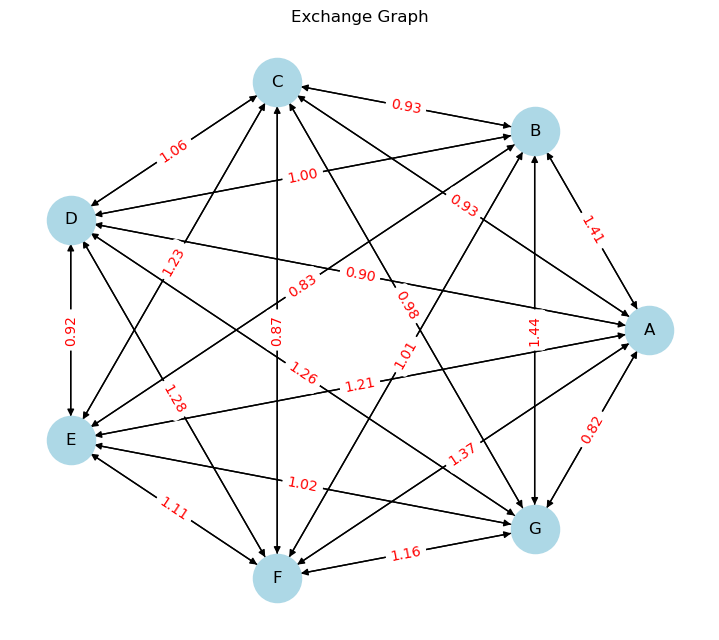

BQM has 42 variables
Running annealing...

Final energy: -14002.0408
Chosen edges: ['A->B', 'B->C', 'C->G', 'G->D', 'D->E', 'E->F', 'F->A']


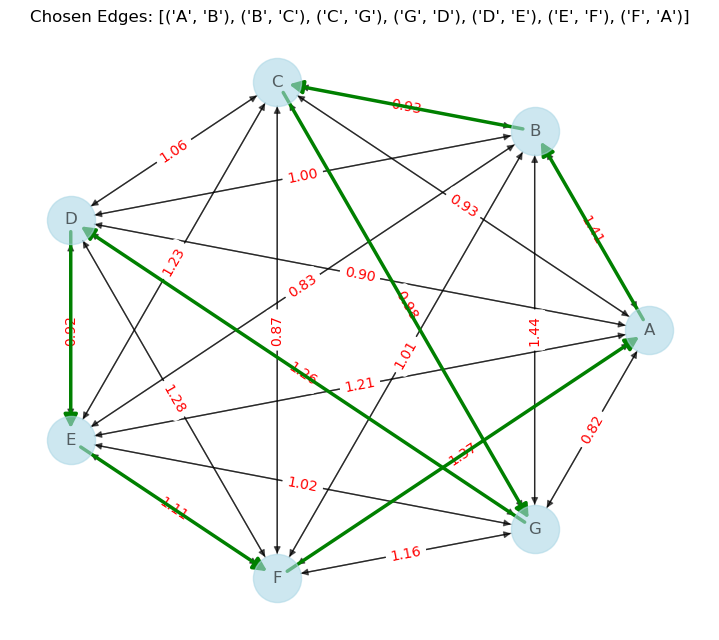

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler  # For simulation

###############################################################################
# 1) DATA GENERATION
###############################################################################
def generate_data(num_currencies=4, seed=42):
    """
    Randomly generate exchange rates and transaction fees.
    """
    np.random.seed(seed)
    currencies = [chr(65 + i) for i in range(num_currencies)]
    exchange_rates = np.random.uniform(0.8, 1.5, size=(num_currencies, num_currencies))
    np.fill_diagonal(exchange_rates, 1.0)

    transaction_fees = np.random.uniform(0.001, 0.01, size=(num_currencies, num_currencies))
    adjusted_rates = exchange_rates - transaction_fees
    log_rates = np.log(adjusted_rates)
    return currencies, exchange_rates, log_rates

def plot_exchange_graph(currencies, exchange_rates):
    """Plot the exchange rate graph."""
    G = nx.DiGraph()
    n = len(currencies)
    for i in range(n):
        for j in range(n):
            if i != j:
                G.add_edge(currencies[i], currencies[j], weight=exchange_rates[i, j])

    pos = nx.circular_layout(G)
    plt.figure(figsize=(7,6))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1200)
    edge_labels = nx.get_edge_attributes(G, "weight")
    edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
    plt.title("Exchange Graph")
    plt.show()

###############################################################################
# 2) ISING MODEL CONSTRUCTION
###############################################################################
def build_arbitrage_bqm(log_rates, penalty=10.0):
    """
    Build Binary Quadratic Model for arbitrage detection.
    Enforces that each currency has exactly one outgoing and one incoming edge.
    """
    N = len(log_rates)
    bqm = BinaryQuadraticModel('BINARY')
    
    def edge_var(i, j):
        return f'x_{i}_{j}'
    
    # Add variables and objective (maximize log rates by minimizing -log_rates)
    for i in range(N):
        for j in range(N):
            if i != j:
                bqm.add_variable(edge_var(i, j))
                bqm.add_linear(edge_var(i, j), -log_rates[i, j])
    
    # Enforce one outgoing and one incoming edge per node.
    for i in range(N):
        out_vars = [edge_var(i, j) for j in range(N) if j != i]
        in_vars = [edge_var(j, i) for j in range(N) if j != i]
        
        # Quadratic penalty for multiple selections among outgoing edges.
        for idx, v1 in enumerate(out_vars):
            for v2 in out_vars[idx+1:]:
                bqm.add_quadratic(v1, v2, 2.0 * penalty)
        # Quadratic penalty for multiple selections among incoming edges.
        for idx, v1 in enumerate(in_vars):
            for v2 in in_vars[idx+1:]:
                bqm.add_quadratic(v1, v2, 2.0 * penalty)
        
        # Linear terms to complete the square (ignoring constant offset).
        for v in out_vars + in_vars:
            bqm.add_linear(v, -penalty)
    
    return bqm

###############################################################################
# 3) ANNEALING AND SOLUTION PROCESSING
###############################################################################
def run_quantum_annealing(bqm, num_reads=1000, use_simulator=True):
    """
    Run either simulated annealing or quantum annealing.
    """
    if use_simulator:
        # Simulated annealing
        sampler = SimulatedAnnealingSampler()
        sampleset = sampler.sample(bqm, num_reads=num_reads)
    else:
        # Quantum annealing on D-Wave hardware
        sampler = EmbeddingComposite(DWaveSampler())
        sampleset = sampler.sample(bqm, num_reads=num_reads, chain_strength=2.0)
    
    return sampleset

def interpret_annealing_solution(sampleset, N, currencies, exchange_rates):
    """
    Process the annealing results and ensure the cycle is valid.
    Returns the cycle (as a list of (from, to) pairs) and the energy.
    """
    best_sample = sampleset.first.sample
    
    # Extract selected edges (still in index space)
    edge_list = []
    for i in range(N):
        for j in range(N):
            if i != j and best_sample.get(f'x_{i}_{j}', 0) == 1:
                edge_list.append((i, j))
    
    # Build graph from selected edges.
    G = nx.DiGraph()
    G.add_edges_from(edge_list)
    
    # Check that every currency has exactly one incoming and one outgoing edge.
    valid_cycle = (len(edge_list) == N and 
                   all(G.in_degree(currency) == 1 and G.out_degree(currency) == 1 
                       for currency in range(N)))
    
    if valid_cycle:
        try:
            cycle_edges = list(nx.find_cycle(G, orientation="original"))
            # Convert numeric indices to currency symbols.
            cycle = [(currencies[u], currencies[v]) for u, v, *_ in cycle_edges]
            return cycle, sampleset.first.energy
        except nx.NetworkXNoCycle:
            print("Warning: Cycle not found even though degrees are valid.")
    else:
        print("Warning: No valid Hamiltonian cycle found in the solution.")
    return [], sampleset.first.energy

###############################################################################
# 4) MAIN PIPELINE
###############################################################################
def quantum_arbitrage_pipeline(N=4, penalty=10.0, seed=42, num_reads=1000, use_simulator=True):
    """
    Main pipeline for the quantum annealing approach to detect arbitrage.
    """
    # Generate data and plot the full exchange graph.
    currencies, exchange_rates, log_rates = generate_data(N, seed=seed)
    plot_exchange_graph(currencies, exchange_rates)
    
    # Build the binary quadratic model.
    bqm = build_arbitrage_bqm(log_rates, penalty=penalty)
    print(f"BQM has {len(bqm.variables)} variables")
    
    # Run the annealing process.
    print("Running annealing...")
    sampleset = run_quantum_annealing(bqm, num_reads=num_reads, use_simulator=use_simulator)
    
    # Process the annealing results.
    edge_list, energy = interpret_annealing_solution(sampleset, N, currencies, exchange_rates)
    print(f"\nFinal energy: {energy:.4f}")
    print("Chosen edges:", [f"{a}->{b}" for a, b in edge_list])
    
    # Plot the final arbitrage cycle.
    plot_cycle(currencies, exchange_rates, edge_list)
    
    return edge_list, energy

def plot_cycle(currencies, exchange_rates, edge_list):
    """
    Plot the full exchange graph with the arbitrage cycle highlighted.
    """
    G = nx.DiGraph()
    n = len(currencies)
    for i in range(n):
        for j in range(n):
            if i != j:
                G.add_edge(currencies[i], currencies[j], weight=exchange_rates[i, j])
    pos = nx.circular_layout(G)

    plt.figure(figsize=(7,6))
    nx.draw(G, pos, node_color='lightblue', node_size=1200, with_labels=True, alpha=0.6)
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for (u, v) in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # edge_list is assumed to have currency labels (e.g. ('A', 'B'))
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='green', width=2.5, arrowsize=20)
    plt.title(f"Chosen Edges: {edge_list}")
    plt.show()

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":
    edge_list, energy = quantum_arbitrage_pipeline(
        N=7,
        penalty=1000.0,
        seed=42,
        num_reads=1000,
        use_simulator=True  # Set to False to use real D-Wave hardware
    )
